###load tools

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 3.4 MB 10.5 MB/s 
     |████████████████████████████████| 596 kB 39.8 MB/s 
     |████████████████████████████████| 61 kB 317 kB/s 
     |████████████████████████████████| 895 kB 42.8 MB/s 
     |████████████████████████████████| 3.3 MB 2.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.9 MB/s 


In [ ]:
import os
import time
import datetime
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer, AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Helper functions

###Tokenize sentences

In [ ]:
def tokenize_sentences(sentences, labels, tokenizer):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  for sent in sentences:    
      encoded_dict = tokenizer(
                          sent,                      # Sentence to encode.
                          #add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 100,           # Pad & truncate all sentences.
                          #padding=True,
                          truncation=True,
                          pad_to_max_length = True,
                          #return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels) - 1

  dataset = TensorDataset(input_ids, attention_masks, labels)
  # Print sentence 0, now as a list of IDs.
  #print('Original: ', sentences[0])
  #print('Token IDs:', input_ids[0])

  return dataset

###Data loader

In [ ]:
def get_data_loaders(train_dataset, val_dataset, batch_size = 8):
  # batch_size = 32

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  return train_dataloader, validation_dataloader

###LR scheduler

In [ ]:
def get_lr_scheduler(train_dataloader, optimizer, epochs):

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, 
                                              num_training_steps = total_steps)
  return scheduler

###Calculate accuracy

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

###Format info

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def format_training_stats(training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)
  df_stats = pd.DataFrame(data=training_stats)
  df_stats = df_stats.set_index('epoch')

  return df_stats

In [ ]:
def format_training_stats(training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)
  df_stats = pd.DataFrame(data=training_stats)
  df_stats = df_stats.set_index('epoch')

  return df_stats

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

def plot_traing_val_loss(df_stats):
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4, 5])

  plt.show()

###Model setup

In [ ]:
# Load the tokenizer. 
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=True)
# Load the model.
# XLMRobertaModel
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    num_labels = 5, 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# run this model on the GPU.
model.cuda()
print('done')

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

done


###Training functions

In [ ]:
def train(model, epochs, train_dataloader, validation_dataloader, scheduler, optimizer, seed_val=22):
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================

      print("")
      print('================ Epoch {:} / {:} ================'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Unpack this training batch from our dataloader. 
          #
          # copy each tensor to the GPU 
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          model.zero_grad()        

          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(b_input_ids, 
                        #token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Progress update every 200 batches.
          if step % 200 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              print('  Batch {:>5,}  of  {:>5,}.  Time elapsed: {:}.  Loss: {}'.format(step, len(train_dataloader), elapsed, loss.item()))

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      for batch in validation_dataloader:
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          loss = result.loss
          logits = result.logits

          total_eval_loss += loss.item()

          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return training_stats

##Train and validate on the source language

In [ ]:
def train_val(train_df, val_df, model=model, epochs=30, tokenizer=tokenizer):
  train_sentences = train_df['review_body'].values
  train_labels = train_df['stars'].values
  train_dataset = tokenize_sentences(train_sentences, train_labels, tokenizer)

  val_sentences = val_df['review_body'].values
  val_labels = val_df['stars'].values 
  val_dataset = tokenize_sentences(val_sentences, val_labels, tokenizer)

  train_dataloader, validation_dataloader = get_data_loaders(train_dataset, val_dataset)
  optimizer = AdamW(model.parameters(),
                  lr = 8e-7, # as suggested
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  scheduler = get_lr_scheduler(train_dataloader, optimizer, epochs)
  training_stats = train(model, epochs, train_dataloader, validation_dataloader, scheduler, optimizer, seed_val=22)

  return training_stats

##Test on all languages

In [ ]:
from sklearn.metrics import mean_absolute_error
def test(test_df, model=model, tokenizer=tokenizer):
  test_sentences = test_df['review_body'].values
  test_labels = test_df['stars'].values
  test_dataset = tokenize_sentences(test_sentences, test_labels, tokenizer)

  prediction_sampler = SequentialSampler(test_dataset)
  prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=32)

  # Prediction on test set

  # print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
    # print(result)
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  flat_predictions = np.concatenate(predictions, axis=0)
  # For each sample, pick the label with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)
  acc = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)
  mae = mean_absolute_error(flat_true_labels, flat_predictions)

  print(str('Test accuracy: {:04.4f}'.format(acc*100))+'%')
  print('Mean absoute error is: {:04.4f}'.format(mae))

  #return predictions , true_labels

#Main (Source language: German)

In [ ]:
!git clone https://github.com/xyyzh/NLP_final_project.git

Cloning into 'NLP_final_project'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), done.
Checking out files: 100% (28/28), done.


##Train and validate

In [ ]:
#!cd NLP_final_project/train/
train_df = pd.read_json("NLP_final_project/train/dataset_de_train_trimmed.json", lines=True)
val_df = pd.read_json("NLP_final_project/val/dataset_de_dev.json", lines=True)

In [ ]:
training_stats = train_val(train_df, val_df, model=model, tokenizer=tokenizer, epochs=5)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



================ Epoch 1 / 5 ================
Training...
  Batch   200  of  3,125.  Time elapsed: 0:00:49.  Loss: 1.5819286108016968
  Batch   400  of  3,125.  Time elapsed: 0:01:38.  Loss: 1.5969624519348145
  Batch   600  of  3,125.  Time elapsed: 0:02:27.  Loss: 1.6187878847122192
  Batch   800  of  3,125.  Time elapsed: 0:03:15.  Loss: 1.6425808668136597
  Batch 1,000  of  3,125.  Time elapsed: 0:04:03.  Loss: 1.544584035873413
  Batch 1,200  of  3,125.  Time elapsed: 0:04:51.  Loss: 1.487502932548523
  Batch 1,400  of  3,125.  Time elapsed: 0:05:39.  Loss: 1.492031455039978
  Batch 1,600  of  3,125.  Time elapsed: 0:06:27.  Loss: 1.3681162595748901
  Batch 1,800  of  3,125.  Time elapsed: 0:07:15.  Loss: 1.5532015562057495
  Batch 2,000  of  3,125.  Time elapsed: 0:08:03.  Loss: 1.2714228630065918
  Batch 2,200  of  3,125.  Time elapsed: 0:08:51.  Loss: 0.8866086006164551
  Batch 2,400  of  3,125.  Time elapsed: 0:09:39.  Loss: 1.296671748161316
  Batch 2,600  of  3,125.  Time e

In [ ]:
df_stats = format_training_stats(training_stats)
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.41,1.09,0.54,0:12:34,0:00:30
2,1.13,1.03,0.55,0:12:34,0:00:30
3,1.08,1.03,0.56,0:12:33,0:00:30
4,1.05,1.02,0.56,0:12:34,0:00:30
5,1.04,1.02,0.56,0:12:34,0:00:30


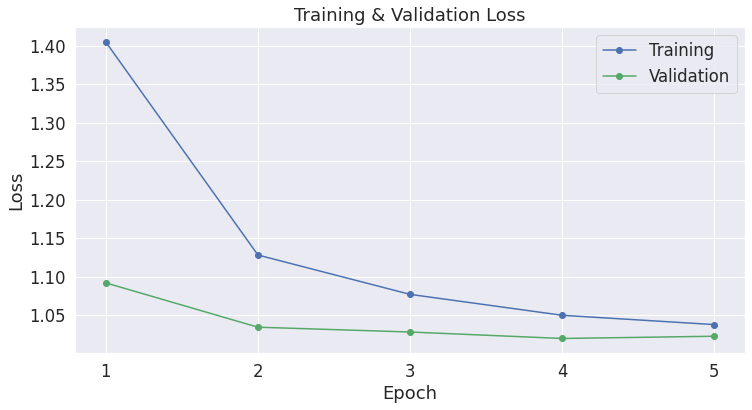

In [ ]:
plot_traing_val_loss(df_stats)

##Test

In [ ]:
en_test = pd.read_json("NLP_final_project/test/dataset_en_test.json", lines=True)
de_test = pd.read_json("NLP_final_project/test/dataset_de_test.json", lines=True)
es_test = pd.read_json("NLP_final_project/test/dataset_es_test.json", lines=True)
fr_test = pd.read_json("NLP_final_project/test/dataset_fr_test.json", lines=True)
ja_test = pd.read_json("NLP_final_project/test/dataset_ja_test.json", lines=True)
zh_test = pd.read_json("NLP_final_project/test/dataset_zh_test.json", lines=True)

/bin/bash: line 0: cd: ../test: No such file or directory


In [ ]:
test(en_test, model=model, tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test accuracy: 53.5600%
Mean absoute error is: 0.5836


In [ ]:
test(de_test, model=model, tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test accuracy: 56.6600%
Mean absoute error is: 0.5044


In [ ]:
test(es_test, model=model, tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test accuracy: 51.2200%
Mean absoute error is: 0.5898


In [ ]:
test(fr_test, model=model, tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test accuracy: 52.0200%
Mean absoute error is: 0.5952


In [ ]:
test(ja_test, model=model, tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test accuracy: 47.6400%
Mean absoute error is: 0.6438


In [ ]:
test(zh_test, model=model, tokenizer=tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Test accuracy: 49.4800%
Mean absoute error is: 0.6840
